In [1]:
%matplotlib inline

import math

from models.vae import get_vae
from models.rnn import get_rnn
from tensorflow.keras.utils import HDF5Matrix
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# Load Data

In [2]:
def scale(a):
    return a / 255

In [3]:
start = 0
end = start + 100
obs = HDF5Matrix('data/train_randomized.h5', 'obs', start=start, end=end, normalizer=scale)
actions = HDF5Matrix('data/train_randomized.h5', 'action', end=end)

# Visualize Autoencoder Recreation

In [5]:
data_shape = (64, 64, 3)
vae = get_vae(data_shape, 32)
vae.load_weights('checkpoints/vae.h5')

In [6]:
predictions = vae.predict(obs)

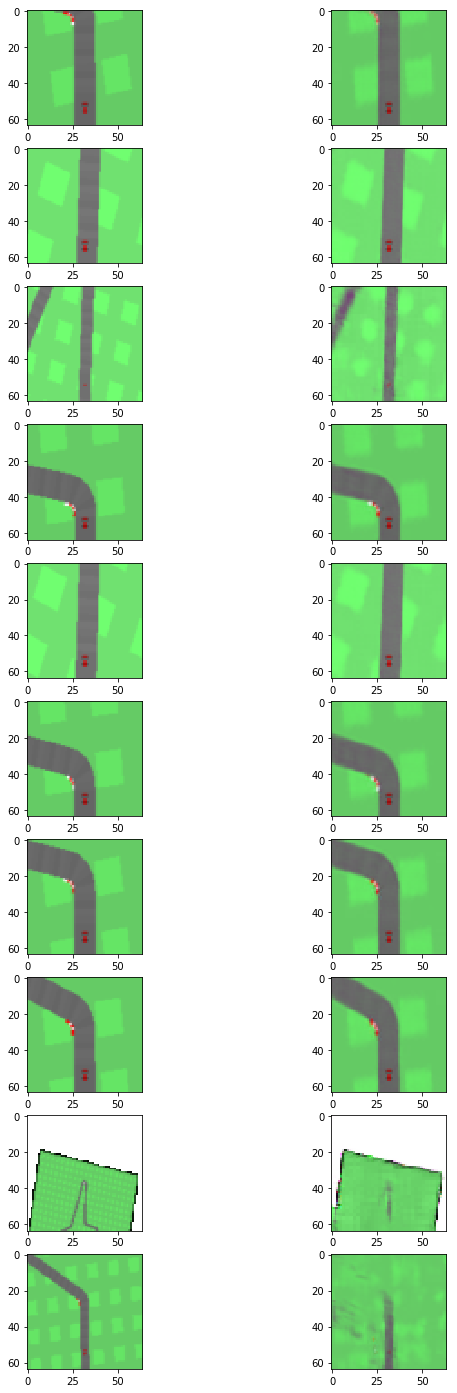

In [7]:
fig, axes = plt.subplots(10, 2, figsize=(10, 25))
for ax, im, gen in zip(axes, obs, predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')

# Visualize Autoencoder Latent Dimension

In [8]:
encoder = Model(inputs=vae.input,
                outputs=vae.get_layer('encoder').output)
out = encoder.predict(obs)

In [31]:
fig, axes = plt.subplots(10, figsize=(15, 15))
for i, ax, in enumerate(axes):
    mu = out[0][0][i]
    sigma = out[1][0][i]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, norm.pdf(x, mu, sigma))

# Visualize RNN Output

In [11]:
rnn_train, rnn_infer = get_rnn((None, 35))
rnn_train.load_weights('checkpoints/rnn.h5')

In [288]:
start_rnn = 550
len_rnn = 100 

obs = HDF5Matrix('data/train.h5', 'obs', start=start_rnn, end=start_rnn+len_rnn, normalizer=scale)
z_true = encoder.predict(obs)[-1]
# z_true = HDF5Matrix('data/train.h5', 'z', start=start_rnn, end=start_rnn+len_rnn)
actions = HDF5Matrix('data/train.h5', 'action', start=start_rnn, end=start_rnn+len_rnn)
rnn_input = np.column_stack([z_true, actions])[:-1]
rnn_input = np.reshape(rnn_input, (-1, 1, 35))

In [289]:
z_pred = rnn_train.predict(rnn_input)
z_pred.shape

(99, 1, 480)

In [290]:
# Defined variables
num_mixtures = 5
output_sequence_width = 32
# Flattened output sequences and mixtures
flat = output_sequence_width*num_mixtures
# Get number of sequences
rollout = np.shape(z_pred)[1]

In [291]:
# Extract flattened variables
logpis_flat = z_pred[:,:,:flat]
mus_flat = z_pred[:,:,flat:flat*2]
sigmas_flat = z_pred[:,:,flat*2:flat*3]
sigmas_flat.shape
# Reshape to (batch, time, num_mixtures, output_sequence_width)
shape = [-1, rollout, num_mixtures, output_sequence_width]
logpis = np.reshape(logpis_flat, shape)
mus = np.reshape(mus_flat, shape)
sigmas = np.reshape(sigmas_flat, shape)
# Send pis through softmax
# pis = np.exp(logpis) / np.sum(np.exp(logpis), axis=2, keepdims=True)
# pis.shape

Now let's sample the distribution using a temperature

In [292]:
temperature = 0.7
logpistemp = np.copy(logpis)/temperature
logpistemp -= logpistemp.max()
pistemp = np.exp(logpistemp)
pistemp /= pistemp.sum(axis=2, keepdims=True)

In [293]:
pitemp = pistemp[:,0,:,:]
mu = mus[:,0,:,:]
sigma = sigmas[:,0,:,:]

In [294]:
def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

In [295]:
pi_idx = np.zeros((pitemp.shape[0], 32))
chosen_mu = np.zeros((pitemp.shape[0], 32))
chosen_sigma = np.zeros((pitemp.shape[0], 32))
for i in range(pitemp.shape[0]):
    for j in range(32):
        idx = get_pi_idx(np.random.rand(), pitemp[i][:,j])
        pi_idx[i,j] = idx
        chosen_mu[i,j] = mu[i][idx][j]
        chosen_sigma[i,j] = sigma[i][idx][j]

In [296]:
rand_gaussian = np.random.normal(size=(pitemp.shape[0], 32))*np.sqrt(temperature)
next_z = chosen_mu+chosen_sigma*rand_gaussian
next_z.shape

(99, 32)

In [297]:
decoder = Model(inputs=vae.get_layer('decoder').input,
                outputs=vae.get_layer('decoder').output)

In [298]:
predictions = decoder.predict(next_z)

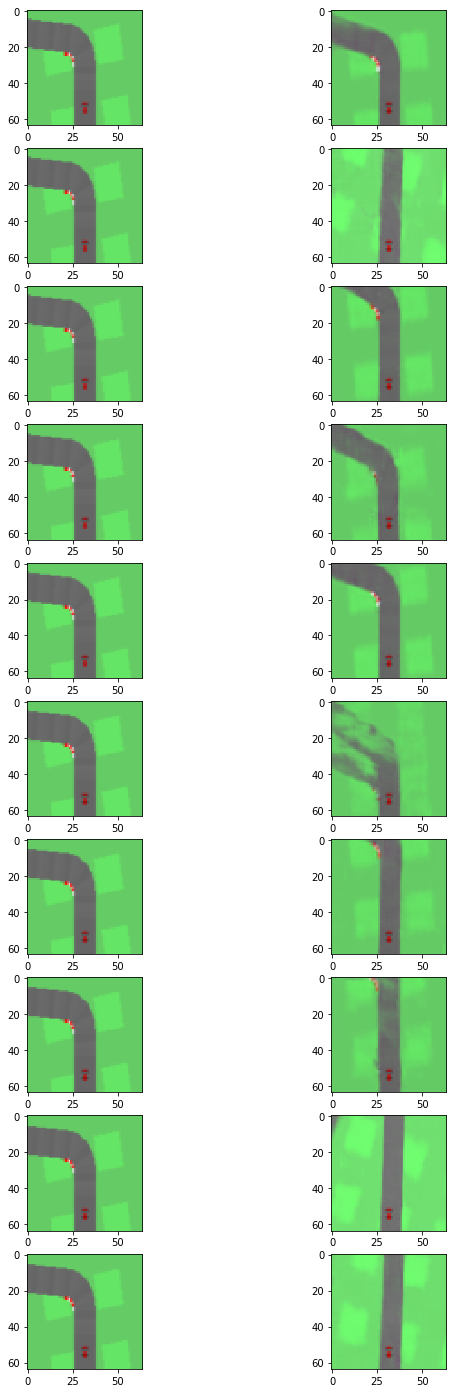

In [299]:
fig, axes = plt.subplots(10, 2, figsize=(10, 25))
for ax, im, gen in zip(axes, obs[1:], predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')